In [1]:
!pip install keras-tuner

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


def setup_dataset(text):
  import shutil
  import os
  %cd /content/gdrive/My Drive/Kaggle/
  strings = text.split(' ')[-1]
  folder = strings.split('/')[1]
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/"+folder
  print(strings)
  print(folder)
  !mkdir $folder
  shutil.copy2("kaggle.json","./"+folder+"/kaggle.json")
  %cd $folder
  !kaggle datasets download -d $strings
  
setup_dataset("kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle
nipunarora8/age-gender-and-ethnicity-face-data-csv
age-gender-and-ethnicity-face-data-csv
mkdir: cannot create directory ‘age-gender-and-ethnicity-face-data-csv’: File exists
/content/gdrive/My Drive/Kaggle/age-gender-and-ethnicity-face-data-csv
age-gender-and-ethnicity-face-data-csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
replace age_gender.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
df = pd.read_csv("age_gender.csv")

In [9]:
df.age.value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: age, Length: 104, dtype: int64

In [10]:
x = np.array(df["pixels"])

In [11]:
x = [item.split(' ') for item in x]

In [12]:
x = [np.array(item).astype(int) for item in x]

In [13]:
np.sqrt(len(x[0]))

48.0

The images are of size 48*48 pixels

In [14]:
x = np.array(x)

In [15]:
x.shape

(23705, 2304)

In [16]:
x = np.reshape(x,(x.shape[0],48,48,1))

In [17]:
x.shape

(23705, 48, 48, 1)

In [18]:
y = np.array(df["age"]).astype(int)

##Train - Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

##Scale images down by 255

In [21]:
x_train = x_train/255.0
x_test = x_test/255.0

In [22]:
x_train[0].shape

(48, 48, 1)

##Model Building

In [23]:
from keras.layers import Conv2D,Flatten,Dense

In [29]:
!rm -r age_prediction

In [30]:
def build_model(hp):
  model = keras.Sequential()  #Model Definition

  for i in range(hp.Int('num_layers',2,12)):       #Select number of hidden layers from 2 to 20
    model.add(Conv2D(
        filters = hp.Int("Conv_"+str(i)+"_filter",min_value = 32,max_value = 128,step = 16),
        kernel_size = hp.Int("Conv_"+str(i)+"_kernel",min_value = 3,max_value = 5,step = 2),
        activation = "relu"     
      )
    )

  model.add(Flatten())

  model.add(Dense(
      units = hp.Int("dense_1_units",min_value = 32,max_value = 128),
      activation = "relu"
    )
  )
  
  model.add(Dense(1,activation="linear"))

  model.compile(
      optimizer = keras.optimizers.Adam(
          hp.Choice('learning_rate',[1e-1,1e-2,1e-3,1e-4]),
      ),
      loss = "mean_squared_logarithmic_error",
      metrics = ["mean_squared_logarithmic_error"]
  )
  return model

In [31]:
from kerastuner import RandomSearch

In [32]:
tuner_search = RandomSearch(build_model,objective="val_mean_squared_logarithmic_error",max_trials=10,directory = "age_prediction",project_name = "age")

In [33]:
tuner_search.search(x_train,y_train,epochs = 3,validation_split = 0.2)

Trial 10 Complete [00h 00m 51s]
val_mean_squared_logarithmic_error: 11.443161964416504

Best val_mean_squared_logarithmic_error So Far: 0.19040144979953766
Total elapsed time: 00h 06m 42s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner_search.results_summary()

Results summary
Results in age_prediction/age
Showing 10 best trials
Objective(name='val_mean_squared_logarithmic_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 5
Conv_0_filter: 48
Conv_0_kernel: 5
Conv_1_filter: 96
Conv_1_kernel: 3
dense_1_units: 71
learning_rate: 0.001
Conv_2_filter: 96
Conv_2_kernel: 5
Conv_3_filter: 64
Conv_3_kernel: 5
Conv_4_filter: 128
Conv_4_kernel: 3
Conv_5_filter: 128
Conv_5_kernel: 3
Conv_6_filter: 48
Conv_6_kernel: 3
Conv_7_filter: 128
Conv_7_kernel: 3
Conv_8_filter: 112
Conv_8_kernel: 3
Conv_9_filter: 128
Conv_9_kernel: 5
Conv_10_filter: 64
Conv_10_kernel: 5
Score: 0.19040144979953766
Trial summary
Hyperparameters:
num_layers: 6
Conv_0_filter: 64
Conv_0_kernel: 3
Conv_1_filter: 112
Conv_1_kernel: 3
dense_1_units: 81
learning_rate: 0.001
Conv_2_filter: 32
Conv_2_kernel: 5
Conv_3_filter: 32
Conv_3_kernel: 5
Conv_4_filter: 96
Conv_4_kernel: 5
Conv_5_filter: 48
Conv_5_kernel: 3
Conv_6_filter: 128
Conv_6_kernel: 5
Conv_7_filter: 32
Conv_7_ke

In [35]:
models = tuner_search.get_best_models(num_models=1)

In [36]:
model = models[0]

In [37]:
model_history = model.fit(x_train,y_train,epochs = 50,validation_split=0.1,initial_epoch=3)

Epoch 4/50
534/534 [==============================] - 16s 28ms/step - loss: 0.1696 - mean_squared_logarithmic_error: 0.1696 - val_loss: 0.1695 - val_mean_squared_logarithmic_error: 0.1695
Epoch 5/50
534/534 [==============================] - 14s 26ms/step - loss: 0.1403 - mean_squared_logarithmic_error: 0.1403 - val_loss: 0.1527 - val_mean_squared_logarithmic_error: 0.1527
Epoch 6/50
534/534 [==============================] - 14s 27ms/step - loss: 0.1188 - mean_squared_logarithmic_error: 0.1188 - val_loss: 0.1301 - val_mean_squared_logarithmic_error: 0.1301
Epoch 7/50
534/534 [==============================] - 14s 27ms/step - loss: 0.1001 - mean_squared_logarithmic_error: 0.1001 - val_loss: 0.1402 - val_mean_squared_logarithmic_error: 0.1402
Epoch 8/50
534/534 [==============================] - 14s 26ms/step - loss: 0.0886 - mean_squared_logarithmic_error: 0.0886 - val_loss: 0.1190 - val_mean_squared_logarithmic_error: 0.1190
Epoch 9/50
534/534 [==============================] - 14s 26

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 48)        1248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 96)        41568     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 96)        230496    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        153664    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 71)                9

In [40]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)

38/38 [==============================] - 3s 30ms/step - loss: 0.0992 - mean_squared_logarithmic_error: 0.0992


In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
print(model_history.history.keys())

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


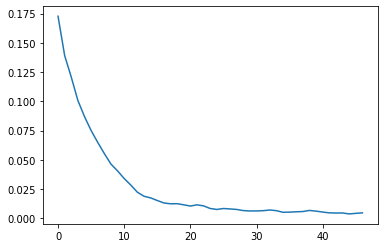

In [42]:
plt.plot(model_history.history["loss"])

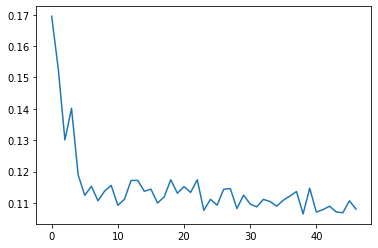

In [43]:
plt.plot(model_history.history["val_loss"])

##Reimagining The Predicted Images

In [45]:
x_test[0].shape

(48, 48, 1)

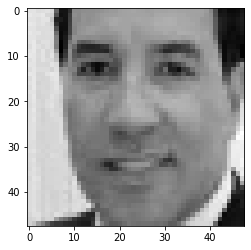

In [62]:
plt.imshow(np.reshape(x_test[450],(48,48)),cmap='gray')

In [64]:
x_test.shape

(4741, 48, 48, 1)

In [48]:
y_pred = model.predict(x_test)

In [63]:
y_pred[450]

array([41.745033], dtype=float32)

In [66]:
import pickle

In [68]:
model.save("cnnmodel")

INFO:tensorflow:Assets written to: cnnmodel/assets


In [69]:
del model  # deletes the existing model

In [71]:
model = keras.models.load_model("cnnmodel")